In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#!pip install pygam
#from pygam import LinearGAM

In [2]:
# load in dataset
# read in UK t2m & NAO data
df = pd.read_csv("ERA5_hourly_UK.csv")
df.columns = ["date_time","t2m","ssrd","msl","nao", "w10","w100"]
df.head()

,date_time,t2m,ssrd,msl,nao,w10,w100
0,1979-01-01 00:00:00,-5.702784,-32767.0,1014.010319,-1.38,0.539450,1.686726
1,1979-01-01 01:00:00,-5.507162,-32767.0,1014.724101,-1.38,0.756348,1.752340
2,1979-01-01 02:00:00,-5.664224,-32767.0,1015.209416,-1.38,1.106655,2.131312
3,1979-01-01 03:00:00,-5.944852,-32767.0,1015.758926,-1.38,1.299900,2.487398
4,1979-01-01 04:00:00,-5.952020,-32767.0,1015.954954,-1.38,1.383135,2.694151


In [3]:
# add week
df["week"] = pd.to_numeric(pd.to_datetime(df.date_time).dt.strftime("%U"))

# Preprocessing

### Split Train/test

In [4]:
# calculate daily values
df.date_time = pd.to_datetime(df.date_time)
df_daily = df.groupby(df.date_time.dt.date).mean()
df_daily["t2mmax"] = t2mmax = df.t2m.groupby(df.date_time.dt.date).max()
df_daily["t2mmin"] = df.t2m.groupby(df.date_time.dt.date).min()

# set X equal to df_daily
X = df_daily

In [5]:
# add lag features
X["t2min_previous"] = X.t2mmin.shift(1)
X["t2m_previous"] = X.t2m.shift(1)
X["t2min_next"] = X.t2mmin.shift(-1)
X["t2m_next"] = X.t2m.shift(-1)
X["w10_previous"] = X.w10.shift(1)
X["w10_next"] = X.w10.shift(-1)
X = X.fillna(0)

In [7]:
# create 24-hour t2m arrays as target variable
Y_list = []
for i in range(int(len(df)/24)):
    Y_list.append(df.w10.iloc[(i*24):(i*24+24)].values)
Y = np.array(Y_list)

# add date_time index
y = pd.DataFrame(Y,index=df_daily.index)

### Visualization of independent vars

In [8]:
#X.hist(figsize=(10,6))

Mostly normal distributions of variables of interest, except ssrd. 

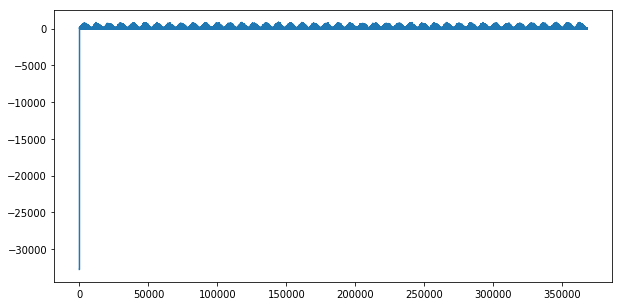

In [9]:
df.ssrd.plot(figsize=(10,5))

Remove outlier from ssrd.

/opt/jaspy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


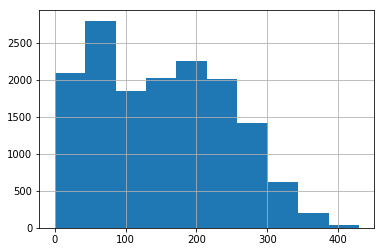

In [10]:
# remove outliers
X.ssrd[X.ssrd<-5000]=0

# produce ssrd plot
X.ssrd.hist()



Split train/test

In [11]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

### Modeling

Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

# produce linear regression
reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [13]:
# metrics
r2_reg = r2_score(y_test,pred_reg)
mae_reg = mean_absolute_error(y_test,pred_reg)
mse_reg = mean_squared_error(y_test,pred_reg)


print("R2-score: ",r2_reg)
print("MAE-score: ",mae_reg)
print("MSE-score: ",mse_reg)



R2-score:  0.8978690268988867
MAE-score:  0.4854414481699964
MSE-score:  0.4350896007708738


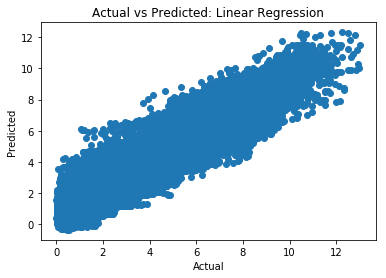

In [14]:
# plot results
plt.scatter(y_test.values.flatten(),pred_reg.flatten())
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Linear Regression")
plt.rcParams["figure.figsize"] = (20,5)

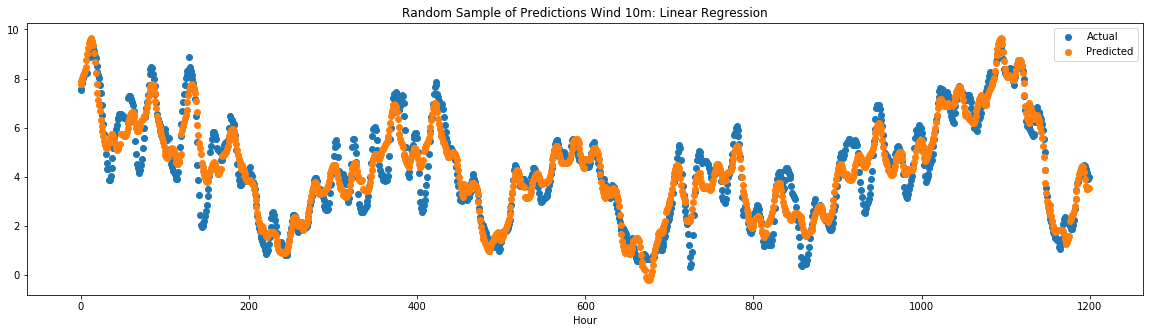

In [16]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_reg[300:350])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind 10m: Linear Regression")
plt.legend(["Actual","Predicted"])

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=60).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [20]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)
mse_rf = mean_squared_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)
print("MSE-score: ",mse_rf)

R2-score:  0.8863980374610628
MAE-score:  0.5085371778194429
MSE-score:  0.4835987691747547


Text(0, 0.5, 'MSE')

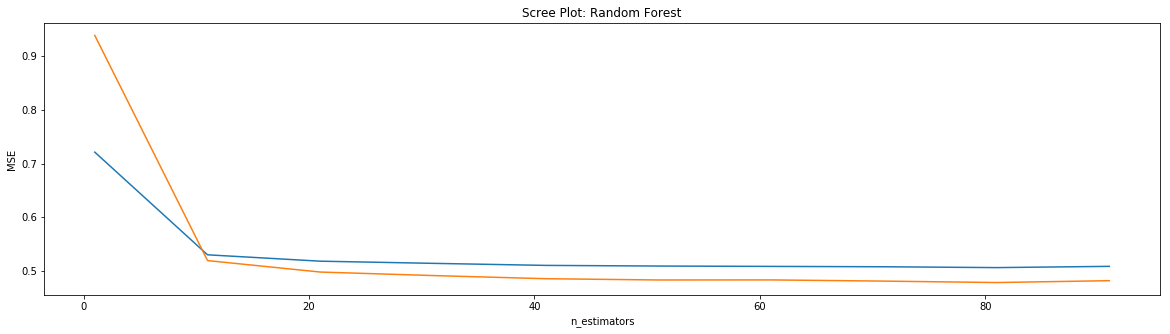

In [21]:
n_estimators = []
mae = []
mse = []
for i in range(1,100,10):
    rf = RandomForestRegressor(n_estimators=i).fit(X_train,y_train)
    pred_rf = rf.predict(X_test)
    n_estimators.append(i)
    mae.append(mean_absolute_error(y_test,pred_rf)) 
    mse.append(mean_squared_error(y_test,pred_rf)) 
n_estimators = np.array(n_estimators)
mae = np.array(mae)
mse = np.array(mse)

plt.plot(n_estimators,mae)
plt.title("Scree Plot: Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("MAE")

plt.plot(n_estimators,mse)
plt.title("Scree Plot: Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("MSE")

Maximum number of trees can be set to 100 as there is little computational cost.

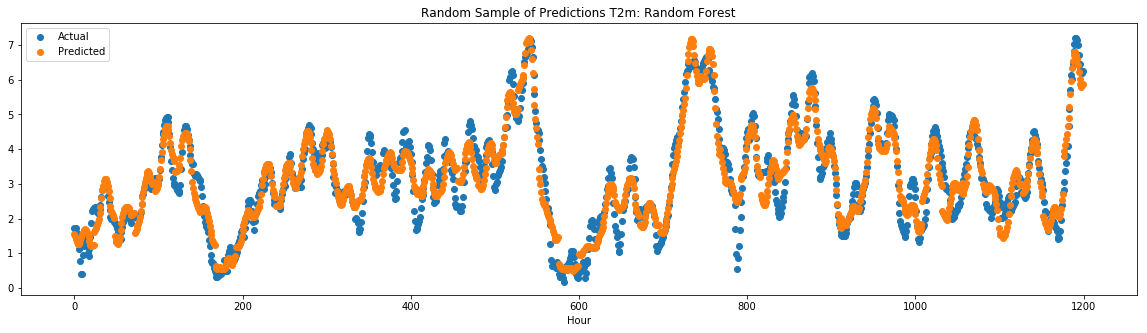

In [22]:
plt.scatter(np.arange(0,50*24,1),y_test.values[4000:4050])
plt.scatter(np.arange(0,50*24,1),pred_rf[4000:4050])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Random Forest")
plt.legend(["Actual","Predicted"])

### Analyze Best Performer

The best performer was Gradient Boosting. 

Below is a visual representation of the seasonal error.

Text(0, 0.5, 'MSE')

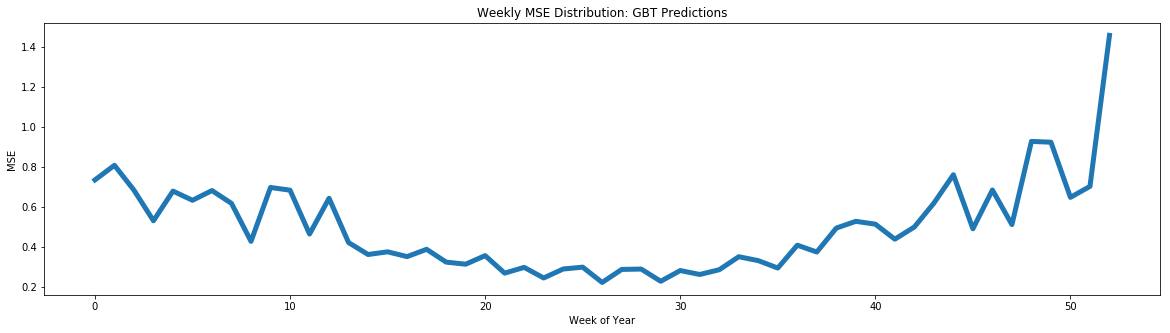

In [25]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_week = se.groupby(se.index.week).mean().mean(axis=1)
plt.plot(np.arange(0,53,1),mse_by_week.values.flatten(),linewidth=5)
plt.title("Weekly MSE Distribution: GBT Predictions")
plt.xlabel("Week of Year")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

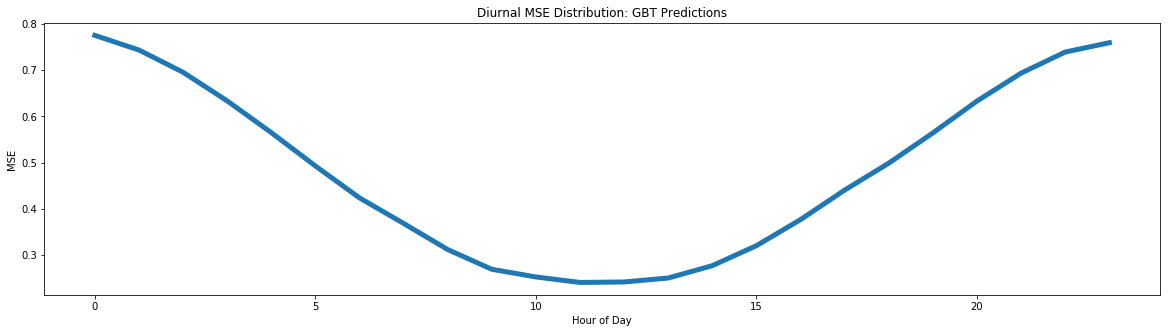

In [26]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_hour = se.groupby(se.index.hour).mean()
plt.plot(np.arange(0,24,1),mse_by_hour.values.flatten(),linewidth=5)
plt.title("Diurnal MSE Distribution: GBT Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("MSE")

Found that winter weeks have higher MSE in comparison to summer months.

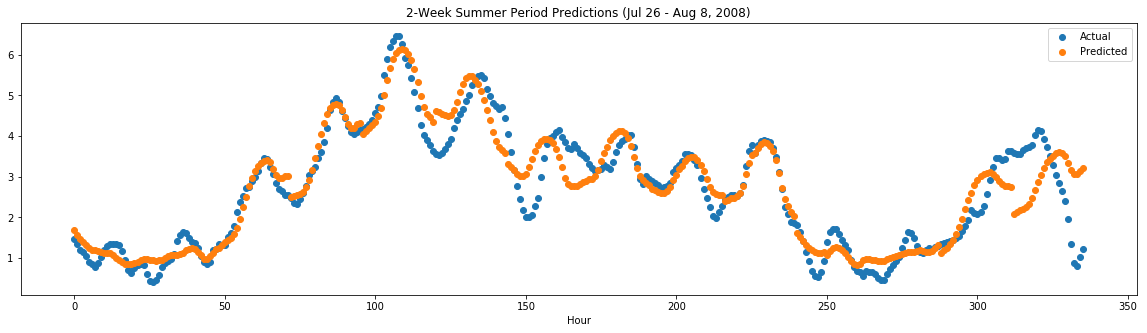

In [27]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_rf[60:74]
pred_d14_winter = pred_rf[230:244]

plt.scatter(np.arange(0,14*24,1),y_d14_summer)
plt.scatter(np.arange(0,14*24,1),pred_d14_summer)
plt.xlabel("Hour")
plt.title("2-Week Summer Period Predictions (Jul 26 - Aug 8, 2008)")
plt.legend(["Actual","Predicted"])

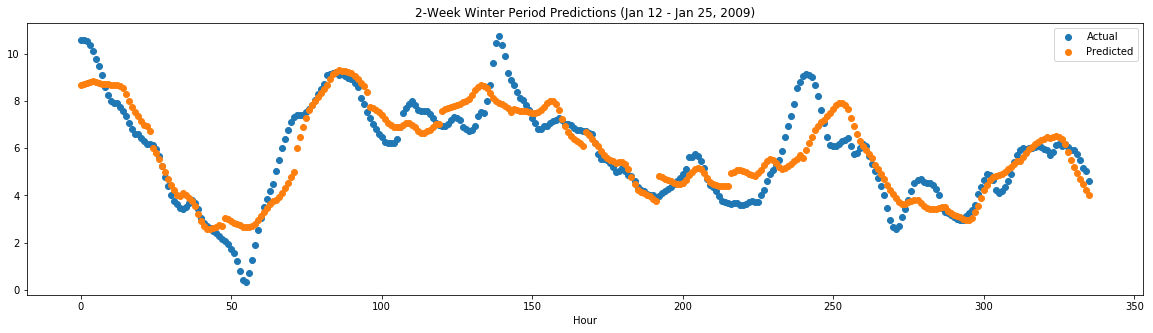

In [28]:
plt.scatter(np.arange(0,14*24,1),y_d14_winter)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Predicted"])

Clearly the model has issues with the extreme fluctuations of temperatures across the UK in the winter months, with predictions unable to capture the variability of the diurnal cycle. Summer months exhibit a more constant diurnal cycle with much better predictions.

In [29]:
def RMS_based_eval(timeseries_for_eval,field,case_no,method_str):

    ''''
    timeseries_for_eval [array] must be the appropriate length for case study evaluation 
    Case1 = 168 hours
    Case2 = 216 hours
    Case3 = 672 hours
    field [str] must either be 'T2m', 'speed10m' , or 'rsds'
    case no [str] must be either 1,2 or 3.
    method_str [str] what you'd like it referred to as.
    '''
    
    obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
    
    obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')
    MAE = np.mean(obs - timeseries_for_eval)
    RMS = np.sqrt(np.nanmean((obs - timeseries_for_eval)**2))
    
    fig = plt.figure(figsize=(12,4))
    plt.plot(obs_date,obs,color='k',label='ERA5 obs')
    if field == 'T2m':
        plt.plot(obs_date,timeseries_for_eval,color='r',label=method_str)
        plt.ylabel('2m temperature ($^{o}$C)',fontsize=14)
        plt.title('Case study ' + case_no )
        plt.xlabel('MAE = ' + str(MAE) + ' , RMS = ' + str(RMS))
    if field == 'speed10m':
        plt.plot(obs_date,timeseries_for_eval,color='b',label=method_str)
        plt.ylabel('10m wind speed (ms$^{-1}$)',fontsize=14)
        plt.title('Case study ' + case_no)
    if field == 'rsds':
        plt.plot(obs_date,timeseries_for_eval,color='gold',label=method_str)
        plt.ylabel('Surface shortwave radiation (Wm$^{-2}$)',fontsize=14)
        plt.title('Case study ' + case_no )
    plt.legend(frameon=False)
    plt.show()
    return([MAE, RMS])

In [30]:
# index y_test to determine dates for case studies
from datetime import datetime

days = pd.to_datetime(y_test.index)
index_case1 = np.where((days>=datetime(2019,11,18)) & (days<=datetime(2019,11,24)))
input_case1 = pred_rf[index_case1].flatten()

index_case2 = np.where((days>=datetime(2020,7,1)) & (days<=datetime(2020,7,9)))
input_case2 = pred_rf[index_case2].flatten()

index_case3 = np.where((days>=datetime(2018,2,20)) & (days<=datetime(2018,3,19)))
input_case3 = pred_rf[index_case3].flatten()

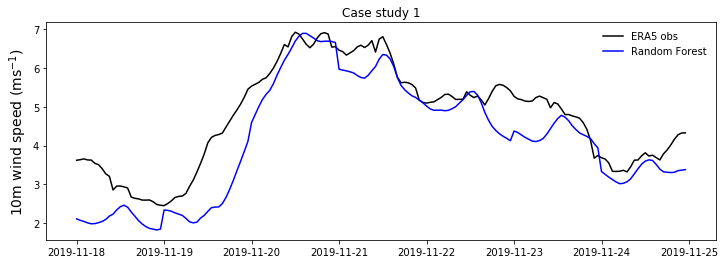

[0.5916689056445562, 0.7943534138802618]

In [31]:
RMS_based_eval(input_case1,"speed10m","1","Random Forest")

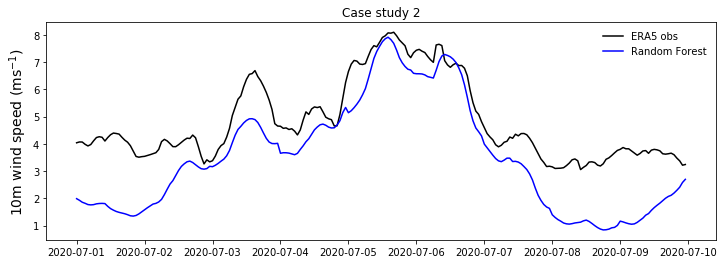

[1.3164656506609143, 1.5499511041383738]

In [32]:
RMS_based_eval(input_case2,"speed10m","2","Random Forest")

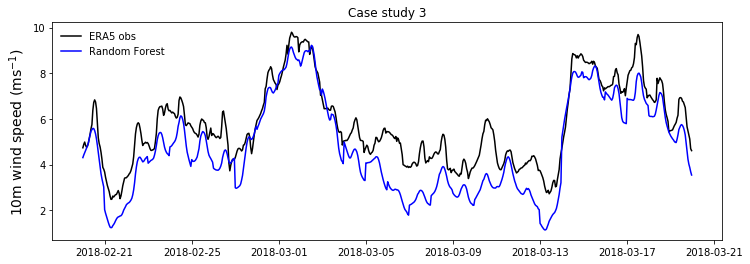

[0.9758816349028295, 1.1774777379573584]

In [33]:
RMS_based_eval(input_case3,"speed10m","3","Random Forest")

t2m               0.003284
ssrd              0.011239
msl               0.009140
nao               0.007610
w10               0.854218
w100              0.010343
week              0.007937
t2mmax            0.004288
t2mmin            0.004788
t2min_previous    0.004771
t2m_previous      0.004226
t2min_next        0.004666
t2m_next          0.004084
w10_previous      0.033196
w10_next          0.036209
dtype: float64

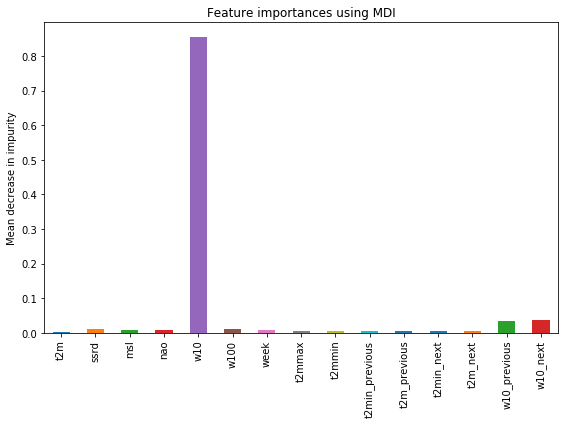

In [34]:
feature_names = X.columns
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

forest_importances